### Adding Router before RAG pipeline

In [23]:
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance, PayloadSchemaType, PointStruct, SparseVectorParams, Document, Prefetch, FusionQuery
from qdrant_client.http.models import models
import pandas as pd
import openai
import fastembed
from langsmith import traceable, get_current_run_tree

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.messages import convert_to_openai_messages, convert_to_messages

from jinja2 import Template
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from instructor import from_openai
from openai import OpenAI

from utils.utils import get_tool_descriptions, format_ai_message
from typing import Annotated, List, Any, Dict
from pydantic import Field, BaseModel
from operator import add
import instructor

from IPython.display import Image, display
from pprint import pprint

In [4]:
from typing import Annotated, List, Any, Dict
from pydantic import Field
from operator import add

class Toolcall(BaseModel):
    name: str
    args: dict
    
class AgentResponse(BaseModel):
    answer: str
    tool_calls: List[Toolcall] = Field(default_factory=list)

class State(BaseModel):
    messages: Annotated[List[Any], add] = []
    user_query: str
    expanded_queries: List[str] = []
    answer: str = ""
    retrieved_contextdata: Annotated[List[Any], add] = []
    query_relevant: bool = False

class QueryRelevanceResponse(BaseModel):
    query_relevant: bool
    reason: str

class QueryRewriteResponse(BaseModel):
    search_queries: List[str]
    
class AggregationResponse(BaseModel):
    answer: str = Field(description="The answer to the question in a list format.")

In [21]:
def create_embeddings(text, model="text-embedding-3-small"):
   
    response = openai.embeddings.create(
        model=model,
        input=text
    )
        
    return response.data[0].embedding

In [5]:
@traceable(name="query_rewriter_node", 
description="This function rewrites the query to be more specific to include multiple statements",
run_type="prompt"
)
def query_rewriter_node(state: State) -> str:
    """
    This function rewrites the query to be more specific to include multiple statements
    """
    
    prompt_template = """
    You are a Shopping Intent Extraction Agent.
    Your task is to analyze a user's complex request and split it into distinct, standalone product search statements.

    ### INSTRUCTIONS
    1. **Identify Entities:** Look for distinct people or needs mentioned (e.g., "for me", "for my kid", "for my wife").
    2. **Segment Requests:** If the user asks for multiple different items, separate them completely. Do not combine them.
    3. **Refine & Standardize:** Convert colloquial phrases into clear, searchable product categories.
        - If the user says "nice toys", convert to "toys for kids" or specific categories if implied.
        - If the user says "I need", infer the target audience based on the context (e.g., "for adults" or "men/women").
    4. **Output List:** Return a raw JSON object containing the list of search statements.
    5. Note: Don't includ below examples in your output.

    ### EXAMPLES

    <Question>
    I need smart watch. My kid needs nice toys. My wife want home appliances.
    </Question>
    <Response>
    {
        "search_queries": [
            "Smart watch for adults",
            "Toys for kids",
            "Home appliances for women"
        ]
    }
    </Response>

    <Question>
    Looking for a gaming laptop for myself and a pink ipad for my daughter.
    </Question>
    <Response>
    {
        "search_queries": [
            "Gaming laptop",
            "Pink iPad for girls"
        ]
    }
    </Response>

    <Question>
    {{ query }}
    </Question>
    <Response>
    """
    
    prompt = Template(prompt_template).render(query=state.user_query)
    
    client = instructor.from_openai(OpenAI())
    
    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4o-mini",
        response_model=QueryRewriteResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.4
    )
    return {
        "expanded_queries": response.search_queries
    }

In [6]:
# making retrieve_embedding_data a retriever node for parallel execution
from typing import Dict

@traceable(name="retrieve_embedding_data", 
description="Retrieve embedding data from Qdrant for a given query and collection name",
run_type="retriever"
)
def retrieve_embedding_node(payload):
    qd_client = QdrantClient(url="http://localhost:6333")
    collection_name = "amazon_items-collection-hybrid-02"
    k=5
    
    query = payload["user_query"]
    querry_embeddings = create_embeddings(query)
    
    response = qd_client.query_points(
        collection_name=collection_name,
        prefetch=[Prefetch(
            query=querry_embeddings,
            using="text-embedding-3-small",
            limit=20),
            Prefetch(
                query=Document(text=query, model="qdrant/bm25"),
                using="bm25",
                limit=20)
            ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )
    retrieved_context_ids = []
    retrieved_context = []
    retrieved_scores = []
    retrieved_context_ratings = []
    
    for point in response.points:
        retrieved_context_ids.append(point.payload["parent_asin"])
        retrieved_context.append(point.payload["description"])
        retrieved_scores.append(point.score)
        retrieved_context_ratings.append(point.payload["average_rating"])

    retrieved_contextdata = []
    for item, context, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        product_context = f"Product ID: {item} - Description: {context} - Rating: {rating}"
        retrieved_contextdata.append(product_context)
    
    return {
        "retrieved_contextdata": retrieved_contextdata
    }

In [18]:
from langgraph.types import Send

@traceable(name="execute_parallel_retrieval", 
description="Retrieve embedding data from Qdrant for a given query and collection name",
run_type="retriever"
)
def execute_parallel_retrieval(state: State) -> List[Send]:
    """
    This function retrieves the embedding data from Qdrant for a given query and collection name
    """    
    send_list = []
    for query in state.expanded_queries:
        send_list.append(Send("retrieve_embedding", {"user_query": query}))
    
    return send_list

In [8]:
@traceable(name="aggregation_node", 
description="This function aggregates the retrieved context data and returns the final answer",
run_type="retriever"
)
def aggregation_node(state: State) -> State:
    """
    This function aggregates the retrieved context data and returns the final answer
    """
    
    prompt_template = """
    You are a specialized Product Expert Assistant. Your goal is to answer customer questions accurately using ONLY the provided product information.

      ### Instructions:
      1. **Source of Truth:** Answer strictly based on the provided "Available Products" section below. Do not use outside knowledge or make assumptions.
      2. **Handling Missing Info:** If the answer cannot be found in the provided products, politely state that you do not have that information. Do not make up features.
      3. **Tone:** Be helpful, professional, and concise.
      4. **Terminology:** Never refer to the text below as "context" or "data." Refer to it naturally as "our current inventory" or "available products."
      5. **output format** - An output of the following format is expected:
          
          1. **Answer:** The answer to the question.
          2. **Context:** The list of the IDs of the chunks that were used to answer the question. Only return the ones that are used in the answer.
          3. **Description:** Short description (1-2 sentences) of the item based on the description provided in the context.

      ### Available Products:
      <inventory_data>
      {{ preprocessed_context }}
      </inventory_data>

      ### Customer Question:
      {{ question }}
      
      ### Expanded Queries by you on the above question:
      {{ expanded_queries }}

      ### Answer:
      """
      
    prompt = Template(prompt_template).render(
                    question=state.user_query, 
                    expanded_queries=state.expanded_queries, 
                    preprocessed_context=state.retrieved_contextdata)
    
    client = instructor.from_openai(OpenAI())
    
    response, raw_response = client.chat.completions.create_with_completion(
    model="gpt-4.1-mini",
    messages=[{"role": "system", "content": prompt}],
    response_model=AggregationResponse,
    temperature=0.4
    )
    
    return {
      "answer": response.answer
    }

In [9]:
# add router node to evaluate the user query and decide the next node to execute
def router_node(state: State) -> State:
    """
    This function evaluates the user query and decides the next node to execute
    """
    prompt_template = """
    You are a Query Relevance Validator for a specific e-commerce product catalog.
    Your job is to classify the user's intent and determine if we need to ask for clarification before proceeding.

    ### Instructions:
    1. **Analyze Intent:** Look at the User Query below.
    2. **Determine Relevance:** - **RELEVANT (true):** The user is asking about buying products, features, comparisons, prices, or inventory.
    - **NOT RELEVANT (false):** The user is asking about topics completely unrelated to shopping (e.g., "How's the weather?").
    3. **Stock & Availability Check:** - If the user asks specifically about **product stock** or **availability** (e.g., "Is this in stock?", "Do you have inventory?"), you MUST request clarification.
    - Set `clarification_needed` to `true`.
    - In the `reason` field, draft a polite clarification question (e.g., "Could you specify which product or store location you are asking about?").
    4. **Output Format:** You must output valid JSON only.

    ### Schema:
    {
        "query_relevant": boolean,
        "clarification_needed": boolean,
        "reason": "string"
    }

    ### User Query:
    {{ question }}

    ### JSON Response:
    """
    
    prompt = Template(prompt_template).render(question=state.user_query)
    
    client = instructor.from_openai(OpenAI())
    
    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4o-mini",
        response_model=QueryRelevanceResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.4
    )
    
    return {
        "query_relevant": response.query_relevant,
        "answer": response.reason
    }

In [10]:
# define the conditional edge to decide the query expansion or end state
from typing import Literal
def router_conditional_edge(state: State) -> Literal["query_rewriter", END]:
    """
    This function decides the next node to execute based on the user query
    """
    if state.query_relevant:
        return "query_rewriter"
    else:
        return END


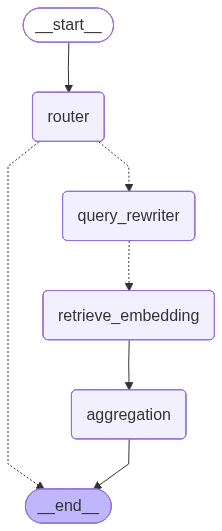

In [26]:
graphbuilder2 = StateGraph(State)

graphbuilder2.add_node("query_rewriter", query_rewriter_node)
graphbuilder2.add_node("retrieve_embedding", retrieve_embedding_node)
graphbuilder2.add_node("router", router_node)
graphbuilder2.add_node("aggregation", aggregation_node)

graphbuilder2.add_edge(START, "router")
graphbuilder2.add_conditional_edges("router", router_conditional_edge, {"query_rewriter": "query_rewriter", END: END})
graphbuilder2.add_conditional_edges("query_rewriter", execute_parallel_retrieval, {"retrieve_embedding": "retrieve_embedding"})
graphbuilder2.add_edge("retrieve_embedding", "aggregation")
graphbuilder2.add_edge("aggregation", END)

agg_graph_1 = graphbuilder2.compile()

display(Image(agg_graph_1.get_graph().draw_mermaid_png()))

In [27]:


initial_state = State(user_query="top laptop under 2000$. Show me the kid toys as well. Nice bags for my daughter")

result = agg_graph_1.invoke(initial_state)

pprint(result["answer"])

('Laptops under $2000:\n'
 '- HP 2022 Newest Pavilion 15.6" FHD 1080P IPS Laptop with AMD Ryzen 7-5700U, '
 '32GB RAM, 1TB NVMe SSD, Windows 11 (Product ID: B09QS7W8G5)\n'
 '- 2022 Newest Lenovo IdeaPad 1 Laptop, 14" Anti-Glare Display, Intel '
 'Quad-Core Processor, 4GB RAM, 128GB PCIe SSD, Windows 11 + Office 365 1-Year '
 'Subscription (Product ID: B015TPLFFO)\n'
 '\n'
 'Kid Toys:\n'
 '- QearFun Dinosaur Headphones for Boys Kids with Microphone & 3.5mm Jack '
 '(Product ID: B0B67M9C9P)\n'
 '- TUNEAKE Kids Headphones, Over Ear, Volume Limited 94dB, Foldable '
 'Adjustable (Product ID: B0C142QS8X)\n'
 '- QearFun Cat Earbuds for Kids with Microphone and Earphones Storage Case '
 '(Product ID: B0B67ZFRPC)\n'
 '- AirTag Bracelet Air Tag Wristband for AirTags Toddler DIY Silicone '
 'Bracelets (Product ID: B0B4N1D73R)\n'
 '- All-New 10 and 10 Plus 2021 Tablet Case for Kids, Shock Proof Kid-Proof '
 'Back Cover (Product ID: B0BL2CZSHT)\n'
 '\n'
 'Nice Bags for Your Daughter:\n'
 '- Missnin

In [28]:
initial_state = State(user_query="which is the best city in India")

result = agg_graph_1.invoke(initial_state)

pprint(result["answer"])

'The query is about the best city in India, which is not related to shopping.'


In [29]:
initial_state = State(user_query="which is the best city in India. Give me top 5 laptops")

result = agg_graph_1.invoke(initial_state)

pprint(result["answer"])

('I do not have information about the best city in India. However, here are '
 'the top 5 laptops from our current inventory based on their features and '
 'ratings:\n'
 '\n'
 '1. ASUS G614JV-AS73 ROG Strix G16 (2023) Gaming Laptop - 16" FHD 165Hz, '
 'GeForce RTX 4060, Intel Core i7-13650HX, 16GB DDR5, 512GB PCIe SSD, Wi-Fi '
 '6E, Windows 11 - Rating: 4.5\n'
 '2. Asus 15.6\'\' ROG Strix G15 Laptop - 15.6" FHD 144Hz, GeForce RTX 3060, '
 'AMD Ryzen 7 4800H, 16GB RAM, 1TB PCIe SSD, Windows 11 Home - Rating: 4.6\n'
 '3. Acer Aspire 5 A515-56-347N Slim Laptop - 15.6" Full HD IPS, 11th Gen '
 'Intel i3-1115G4, 8GB DDR4, 128GB NVMe SSD, WiFi 6, Windows 11 Home in S Mode '
 '- Rating: 4.3\n'
 '4. Lenovo Newest Ideapad 15.6" Laptop - 15.6" HD IPS, AMD Dual-core '
 'Processor, 4GB RAM, 128GB PCIe SSD, WiFi 6, Windows 11 Home in S Mode - '
 'Rating: 4.4\n'
 '5. jumper Laptop - 16 Inch FHD IPS, Intel Celeron Quad Core CPU, 4GB DDR4, '
 '128GB Storage, Windows 11, Office 365 1-Year Subscription 